In [ ]:
# Import necessary libraries for data analysis and machine learning
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# FIX for Windows joblib warning
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # Change to your CPU core count

# Suppress warnings
warnings.filterwarnings('ignore')

# Import sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, auc,
                             classification_report)

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [ ]:
# Load the dataset
# Display header
print("=" * 70)
print("CUSTOMER CHURN PREDICTION - RESEARCH IMPLEMENTATION")
print("=" * 70)

CSV_FILE_PATH = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'

try:
    df = pd.read_csv(CSV_FILE_PATH)
    print(f"✓ Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print(f"❌ File not found. Creating sample dataset...")
    df = pd.DataFrame({
        'customerID': ['C' + str(i) for i in range(1, 101)],
        'gender': np.random.choice(['Male', 'Female'], 100),
        'SeniorCitizen': np.random.choice([0, 1], 100, p=[0.85, 0.15]),
        'tenure': np.random.randint(1, 72, 100),
        'MonthlyCharges': np.random.uniform(20, 120, 100),
        'TotalCharges': np.random.uniform(100, 8000, 100),
        'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], 100),
        'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], 100),
        'Churn': np.random.choice(['Yes', 'No'], 100, p=[0.3, 0.7])
    })

df.head()

CUSTOMER CHURN PREDICTION - RESEARCH IMPLEMENTATION
✓ Dataset loaded successfully!
Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Data Preprocessing
print("\n[STEP 2] DATA PREPROCESSING")
print("-" * 70)

df_processed = df.copy()

# Find target column
target_column = None
for col_name in ['Churn', 'churn', 'Target', 'target']:
    if col_name in df_processed.columns:
        target_column = col_name
        break

if target_column is None:
    target_column = df_processed.columns[-1]

print(f"Target column: '{target_column}'")

# Handle TotalCharges
if 'TotalCharges' in df_processed.columns:
    df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
    df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median(), inplace=True)

# Drop ID columns
for col in ['customerID', 'CustomerID']:
    if col in df_processed.columns:
        df_processed.drop(col, axis=1, inplace=True)

# Convert target to binary
if df_processed[target_column].dtype == 'object':
    df_processed[target_column] = df_processed[target_column].map({'Yes': 1, 'No': 0})

print(f"Churn Rate: {df_processed[target_column].mean()*100:.2f}%")


[STEP 2] DATA PREPROCESSING
----------------------------------------------------------------------
Target column: 'Churn'
Churn Rate: 26.54%



[STEP 3] EXPLORATORY DATA ANALYSIS


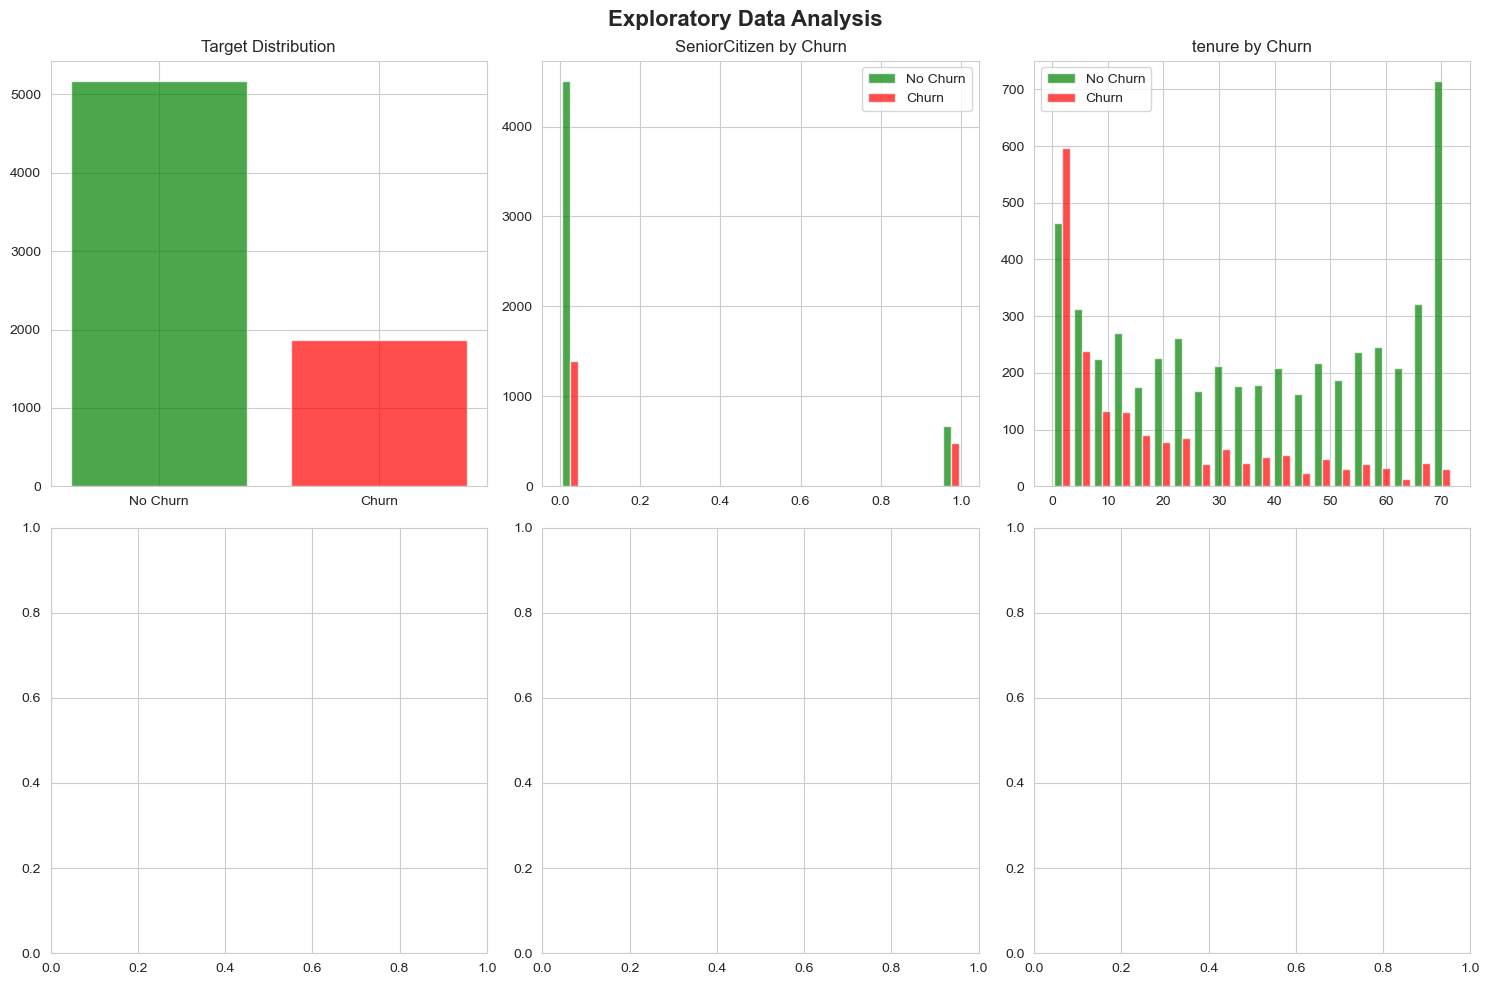

In [31]:
# Exploratory Data Analysis
print("\n[STEP 3] EXPLORATORY DATA ANALYSIS")
# EDA Visualisations
numeric_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
if target_column in numeric_cols:
    numeric_cols.remove(target_column)

categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Exploratory Data Analysis', fontsize=16, fontweight='bold')

# Churn distribution
axes[0, 0].bar(['No Churn', 'Churn'], df_processed[target_column].value_counts().sort_index().values, 
               color=['green', 'red'], alpha=0.7)
axes[0, 0].set_title('Target Distribution')

# Numeric features
for idx, col in enumerate(numeric_cols[:2]):
    ax = axes[0, idx+1]
    ax.hist([df_processed[df_processed[target_column]==0][col], 
            df_processed[df_processed[target_column]==1][col]], 
            bins=20, label=['No Churn', 'Churn'], color=['green', 'red'], alpha=0.7)
    ax.set_title(f'{col} by Churn')
    ax.legend()

# Categorical features
for idx, col in enumerate(categorical_cols[:3]):
    ax = axes[1, idx]
    churn_crosstab = pd.crosstab(df_processed[col], df_processed[target_column], normalize='index') * 100
    churn_crosstab.plot(kind='bar', ax=ax, color=['green', 'red'], alpha=0.7)
    ax.set_title(f'Churn by {col}')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Feature Encoding
print("\n[STEP 4] FEATURE ENCODING")

label_encoders = {}
categorical_cols = df_processed.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le

X = df_processed.drop(target_column, axis=1)
y = df_processed[target_column]

print(f"Features: {X.shape}, Target: {y.shape}")


[STEP 4] FEATURE ENCODING
Features: (7043, 19), Target: (7043,)


In [ ]:
# Train-Test Split and Feature Scaling
print("\n[STEP 5] TRAIN-TEST SPLIT")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {len(X_train)}, Testing: {len(X_test)}")
print("✓ Features scaled")


[STEP 5] TRAIN-TEST SPLIT
Training: 5282, Testing: 1761
✓ Features scaled


In [ ]:
# Model Training
print("\n[STEP 6] MODEL TRAINING")

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine': SVC(random_state=42, probability=True)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"  Accuracy: {results[name]['accuracy']:.4f}")


[STEP 6] MODEL TRAINING

Training Logistic Regression...
  Accuracy: 0.8030

Training Decision Tree...
  Accuracy: 0.7547

Training Random Forest...
  Accuracy: 0.7905

Training Gradient Boosting...
  Accuracy: 0.7978

Training K-Nearest Neighbors...
  Accuracy: 0.7456

Training Support Vector Machine...
  Accuracy: 0.7944


In [33]:
# Model Evaluation and Comparison
print("\n[STEP 7] MODEL EVALUATION AND COMPARISON")

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()]
})

best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
print(f"🏆 Best Model: {best_model_name}")

comparison_df


[STEP 7] MODEL EVALUATION AND COMPARISON
🏆 Best Model: Logistic Regression


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.802953,0.649254,0.558887,0.600690
1,Decision Tree,0.754685,0.537313,0.539615,0.538462
2,Random Forest,0.790460,0.642442,0.473233,0.545006
3,Gradient Boosting,0.797842,0.663717,0.481799,0.558313
4,K-Nearest Neighbors,0.745599,0.520879,0.507495,0.514100
5,Support Vector Machine,0.794435,0.653959,0.477516,0.551980



[STEP 8] VISUALISATION OF MODEL PERFORMANCE COMPARISON


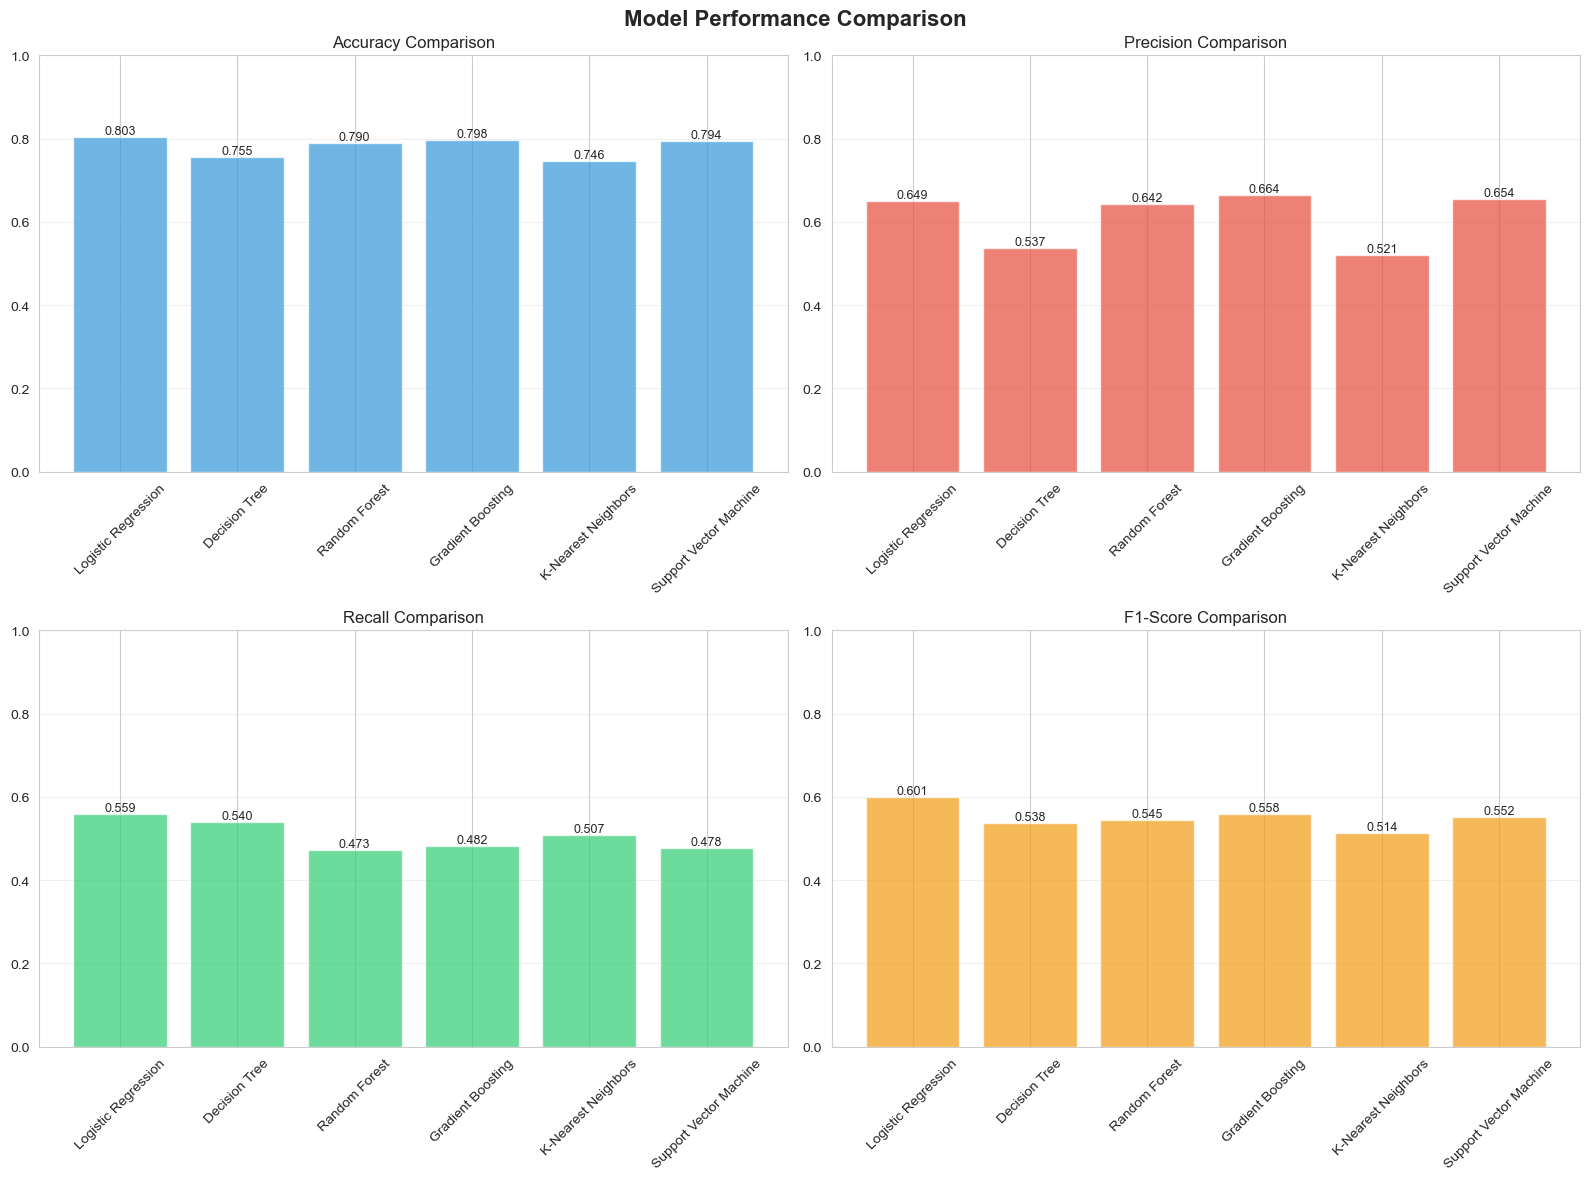

In [38]:
# Visualisation - Performance Comparison
print("\n[STEP 8] VISUALISATION OF MODEL PERFORMANCE COMPARISON")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors[idx], alpha=0.7)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


[STEP 9] ROC CURVES


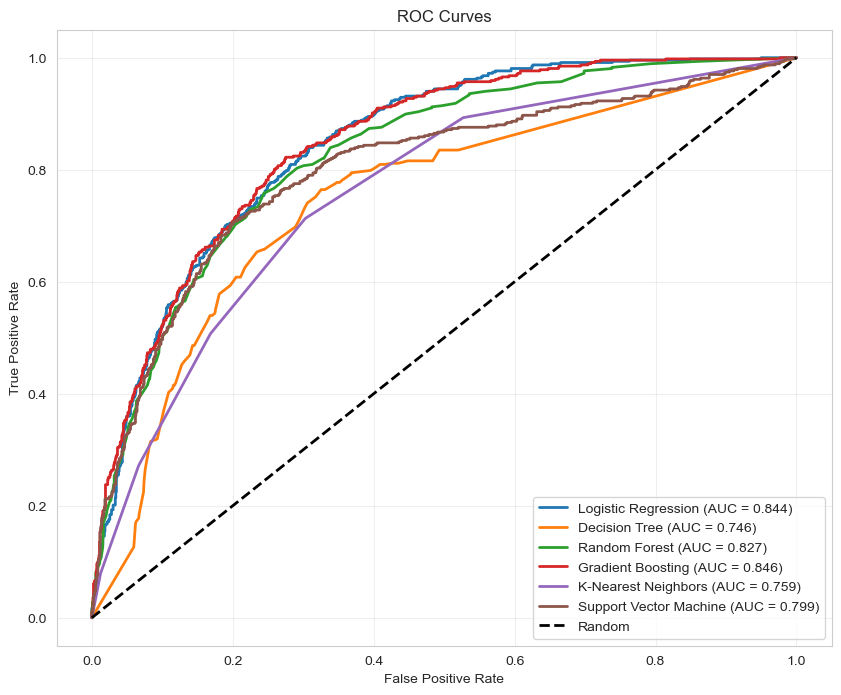

In [39]:
# ROC Curves
print("\n[STEP 9] ROC CURVES")
fig, ax = plt.subplots(figsize=(10, 8))

for name in results.keys():
    if results[name]['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.show()


[STEP 10] CONFUSION MATRIX FOR BEST MODEL


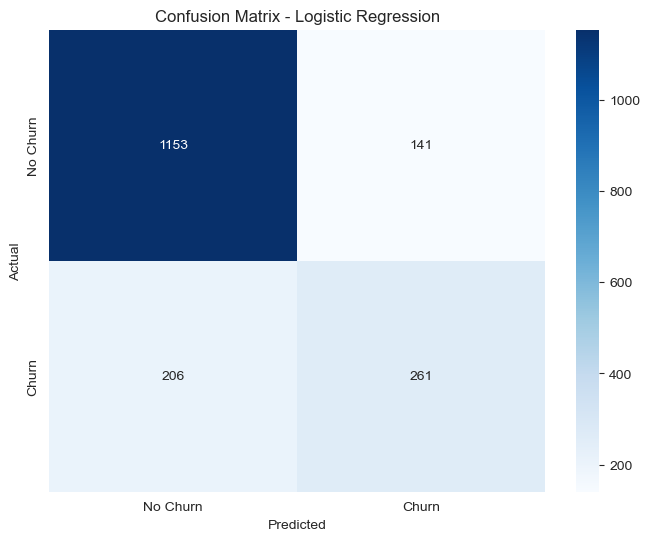

In [40]:
# Confusion Matrix for Best Model
print("\n[STEP 10] CONFUSION MATRIX FOR BEST MODEL")
best_model_results = results[best_model_name]
cm = confusion_matrix(y_test, best_model_results['y_pred'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
ax.set_title(f'Confusion Matrix - {best_model_name}')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.show()


[STEP 11] FEATURE IMPORTANCE VISUALISATION

⚠️  Logistic Regression does not support feature importance visualization
Feature importance is only available for tree-based models:
  - Random Forest
  - Gradient Boosting
  - Decision Tree

[BONUS] Feature Importance from Random Forest
----------------------------------------------------------------------


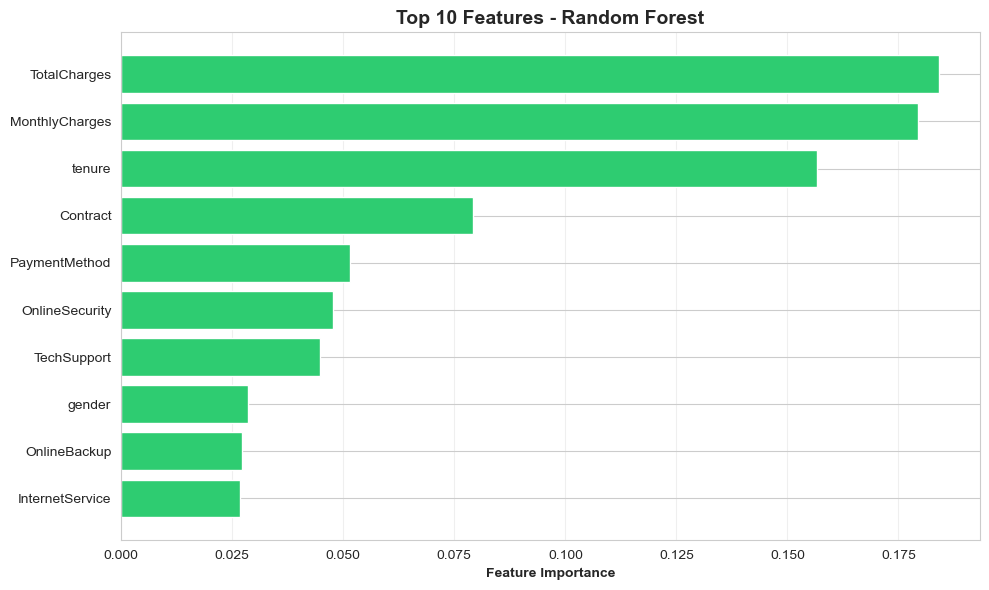


Top 5 Most Important Features:
1. TotalCharges: 0.1841
2. MonthlyCharges: 0.1794
3. tenure: 0.1567
4. Contract: 0.0791
5. PaymentMethod: 0.0516


In [ ]:
# Feature Importance Visualisation
print("\n[STEP 11] FEATURE IMPORTANCE VISUALISATION")
if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
    feature_importance = best_model_results['model'].feature_importances_
    indices = np.argsort(feature_importance)[::-1][:min(10, len(X.columns))]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(range(len(indices)), feature_importance[indices], color='#2ecc71')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([X.columns[i] for i in indices])
    ax.set_xlabel('Feature Importance', fontweight='bold')
    ax.set_title(f'Top 10 Features - {best_model_name}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"\n⚠️  {best_model_name} does not support feature importance visualisation")
    print(f"Feature importance is only available for tree-based models:")
    print("  - Random Forest")
    print("  - Gradient Boosting")
    print("  - Decision Tree")
    # Show feature importance for Random Forest (even if it's not the best model)
    print("\n[BONUS] Feature Importance from Random Forest")
    print("-" * 70)

    rf_model = results['Random Forest']['model']
    feature_importance = rf_model.feature_importances_
    indices = np.argsort(feature_importance)[::-1][:min(10, len(X.columns))]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(range(len(indices)), feature_importance[indices], color='#2ecc71')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([X.columns[i] for i in indices])
    ax.set_xlabel('Feature Importance', fontweight='bold')
    ax.set_title('Top 10 Features - Random Forest', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print top 5 features
    print("\nTop 5 Most Important Features:")
    for i, idx in enumerate(indices[:5], 1):
        print(f"{i}. {X.columns[idx]}: {feature_importance[idx]:.4f}")